<a href="https://colab.research.google.com/github/Mario-td/Human-Activity-Recognition-using-1D-CNN-and-LSTM/blob/master/HAR_using_1D_CNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(tf.__version__)

2.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Label of the classes
LABELS = [    
    'JUMPING',
    'JUMPING_JACKS',
    'BOXING',
    'WAVING_2HANDS',
    'WAVING_1HAND',
    'CLAPPING_HANDS'
] 

# Dataset path
path = '/content/drive/My Drive/Colab Notebooks/RNN-HAR-2D-Pose-database/'

# Load the dataset
data = pd.read_csv(path + '/HAR.csv')

In [ ]:
# Data visualization
data

,Label,Sequence,j0_x,j0_y,j1_x,j1_y,j2_x,j2_y,j3_x,j3_y,j4_x,j4_y,j5_x,j5_y,j6_x,j6_y,j7_x,j7_y,j8_x,j8_y,j9_x,j9_y,j10_x,j10_y,j11_x,j11_y,j12_x,j12_y,j13_x,j13_y,j14_x,j14_y,j15_x,j15_y,j16_x,j16_y,j17_x,j17_y
0,0,0,295.914,161.579,307.693,203.413,281.546,203.368,274.997,251.562,267.194,293.253,337.619,204.669,347.958,255.443,341.541,295.866,286.810,289.393,297.196,355.832,297.220,405.371,321.967,291.959,327.143,358.408,328.528,411.922,294.546,156.420,305.002,156.418,0.000,0.000,318.083,161.632
1,0,1,295.855,161.600,307.684,203.408,281.529,203.385,274.989,251.574,267.191,291.961,337.615,204.646,347.974,254.209,344.093,295.816,286.803,289.377,297.165,355.827,297.205,404.095,323.248,290.652,324.564,358.409,328.493,410.630,293.252,157.686,303.706,157.706,0.000,0.000,318.024,161.654
2,0,2,293.296,161.620,307.655,203.410,280.228,203.382,274.986,251.591,267.262,289.373,337.590,204.656,348.003,255.468,341.536,295.919,286.826,291.959,295.882,357.139,297.209,402.798,324.527,290.690,321.931,359.707,328.522,411.946,289.374,157.686,299.798,157.714,0.000,0.000,316.776,161.679
3,0,3,291.978,161.658,307.619,204.678,278.918,204.659,275.001,254.114,269.794,289.363,337.571,205.963,348.004,255.514,342.818,295.928,288.041,291.984,294.585,358.396,297.243,402.814,324.536,293.275,319.335,359.713,328.479,411.947,288.101,157.727,298.487,158.985,0.000,0.000,316.720,161.697
4,0,4,288.063,168.120,306.362,209.835,276.384,211.108,275.010,255.461,275.003,294.581,336.288,209.847,348.017,258.065,340.210,302.403,288.111,294.598,293.282,359.758,297.246,405.358,325.820,294.576,318.062,362.343,329.774,411.884,286.774,161.596,297.133,161.601,0.000,0.000,315.402,166.840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908027,5,27,366.269,118.668,349.300,159.042,328.442,160.358,316.776,212.464,320.671,255.444,370.127,156.421,379.248,202.021,391.035,235.928,337.636,241.127,332.389,306.333,327.177,367.581,367.570,239.817,358.466,304.959,355.854,357.130,358.425,114.723,367.533,113.418,340.189,119.987,0.000,0.000
908028,5,28,366.290,118.670,349.308,160.266,328.439,161.576,316.781,212.448,318.045,255.522,370.154,157.689,378.004,202.044,388.451,241.108,337.586,241.120,331.086,306.329,327.169,367.594,367.598,239.840,358.471,304.982,355.845,357.134,358.445,115.974,367.545,113.419,340.209,119.993,0.000,0.000
908029,5,29,366.263,118.653,349.319,160.252,328.466,160.384,316.780,211.146,316.759,252.873,370.159,156.410,376.686,202.005,383.217,237.257,338.875,241.118,331.102,306.303,327.178,367.599,368.851,239.836,358.454,304.985,355.851,357.136,358.409,114.716,367.550,113.382,340.198,119.966,0.000,0.000
908030,5,30,366.268,118.629,349.311,160.253,328.475,161.605,316.763,212.470,316.719,254.155,370.138,155.125,371.479,202.000,379.347,237.242,338.939,241.113,331.102,306.280,327.180,368.816,368.844,239.831,358.454,304.961,355.854,357.127,358.398,114.702,367.562,112.092,340.203,119.970,0.000,0.000


In [ ]:
# Get the number of frames per sample
n_steps = max(data['Sequence']) + 1
n_steps

32

In [ ]:
# Get the labels
Y_ = np.array(data['Label'][0::n_steps][:], dtype=np.int32)
Y_.size

28376

In [ ]:
# Get the data
X_ = pd.DataFrame.to_numpy(data[data.columns[2:]])
# Split into the number of samples
X_ = np.array(np.split(X_, Y_.size))
X_.shape

(28376, 32, 36)

In [ ]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.2) #, random_state=2

In [ ]:
print('X_train shape '+ str(X_train.shape))
print('X_test shape '+ str(X_test.shape))

X_train shape (22700, 32, 36)
X_test shape (5676, 32, 36)


In [ ]:
# Hyperparameters and input data

# Number of input parameters per timestep
n_input = len(X_[0][0])

n_classes = 6 

y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

batch_size = 32 * n_steps
n_epochs = 120

In [ ]:
# Exponential Decay Learning Rate
initial_learning_rate = 0.002
decay_rate = 0.95
decay_steps = 100 
decayed_lr = tf.keras.optimizers.schedules.ExponentialDecay(
              initial_learning_rate, decay_steps, decay_rate, staircase=False)

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    lr = self.model.optimizer._decayed_lr('float32').numpy()
    print('\nLearning rate: {}'.format(lr))

In [ ]:
# Reshape data into time steps of sub-sequences
n_sub_steps, n_length = 4, 8

X_train = tf.reshape(X_train,(X_train.shape[0], n_sub_steps, n_length, n_input))
X_test = X_test.reshape((X_test.shape[0], n_sub_steps, n_length, n_input))

In [ ]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_input)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=decayed_lr, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])

t_start = time.time()

history = model.fit(X_train, y_train, shuffle=True, batch_size=batch_size, epochs=n_epochs, callbacks=[MyCustomCallback()])

t_stop = time.time() 
print( "Training time: " + str(datetime.timedelta(seconds= t_stop - t_start)))


Learning rate: 0.0020000000949949026
Epoch 1/120
23/23 [==============================] - 3s 143ms/step - loss: 1.7635 - accuracy: 0.2161

Learning rate: 0.001976543804630637
Epoch 2/120
23/23 [==============================] - 3s 143ms/step - loss: 1.7267 - accuracy: 0.2426

Learning rate: 0.001953362487256527
Epoch 3/120
23/23 [==============================] - 3s 143ms/step - loss: 1.6923 - accuracy: 0.2685

Learning rate: 0.0019304532324895263
Epoch 4/120
23/23 [==============================] - 3s 141ms/step - loss: 1.6566 - accuracy: 0.2830

Learning rate: 0.0019078126642853022
Epoch 5/120
23/23 [==============================] - 3s 142ms/step - loss: 1.5904 - accuracy: 0.3455

Learning rate: 0.0018854375230148435
Epoch 6/120
23/23 [==============================] - 3s 140ms/step - loss: 1.4220 - accuracy: 0.4280

Learning rate: 0.0018633248982951045
Epoch 7/120
23/23 [==============================] - 3s 140ms/step - loss: 1.2832 - accuracy: 0.4753

Learning rate: 0.00184147153

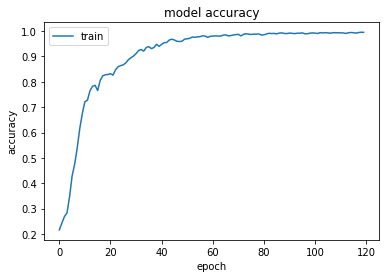

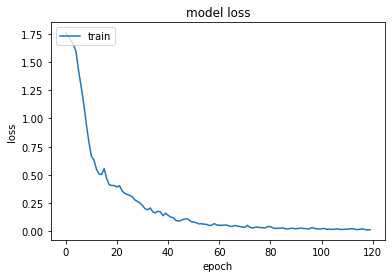

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train'], loc='upper left') 
plt.show()

# Summarize history for loss
plt.plot(history.history['loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train'], loc='upper left') 
plt.show()

In [ ]:
# Test accuracy
model.evaluate(X_test, y_test)

178/178 [==============================] - 1s 3ms/step - loss: 0.0149 - accuracy: 0.9951


[0.014943537302315235, 0.9950669407844543]

In [ ]:
predicted_classes = model.predict_classes(X_test) 

# Sets the actual test label with the same format
y_test = y_test.argmax(1)

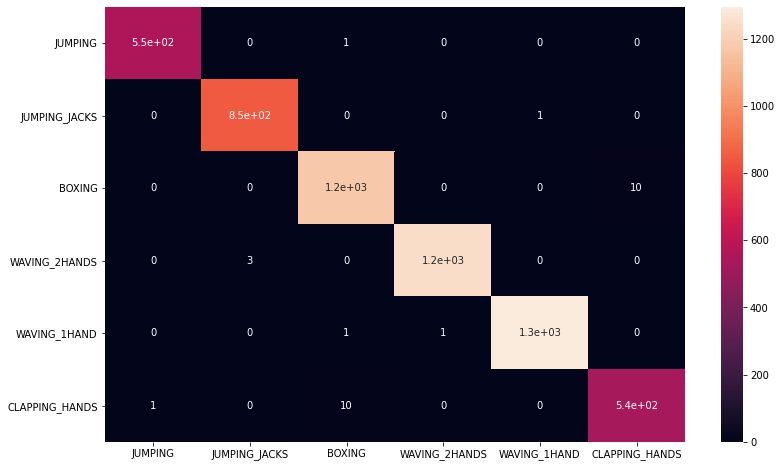

In [ ]:
cm = confusion_matrix(predicted_classes, y_test)
plt.figure(figsize = (13, 8))
sns.heatmap(cm, annot = True, xticklabels = LABELS, yticklabels = LABELS)